In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import LabelEncoder

In [9]:
#Importing the Data
pizza_df= pd.read_csv(r"C:\Users\hp\Desktop\Dominos\Pizza_Sale - pizza_sales.csv")
Ingredients_dataset = pd.read_csv(r"C:\Users\hp\Desktop\Dominos\Pizza_ingredients - Pizza_ingredients.csv")

In [11]:
pizza_df.dropna(inplace=True)


In [13]:
pizza_df.head()


,pizza_id,order_id,pizza_name_id,quantity,order_date,order_time,unit_price,total_price,pizza_size,pizza_category,pizza_ingredients,pizza_name
0,1,1,hawaiian_m,1,1/1/2015,11:38:36,13.25,13.25,M,Classic,"Sliced Ham, Pineapple, Mozzarella Cheese",The Hawaiian Pizza
1,2,2,classic_dlx_m,1,1/1/2015,11:57:40,16.00,16.00,M,Classic,"Pepperoni, Mushrooms, Red Onions, Red Peppers,...",The Classic Deluxe Pizza
2,3,2,five_cheese_l,1,1/1/2015,11:57:40,18.50,18.50,L,Veggie,"Mozzarella Cheese, Provolone Cheese, Smoked Go...",The Five Cheese Pizza
3,4,2,ital_supr_l,1,1/1/2015,11:57:40,20.75,20.75,L,Supreme,"Calabrese Salami, Capocollo, Tomatoes, Red Oni...",The Italian Supreme Pizza
4,5,2,mexicana_m,1,1/1/2015,11:57:40,16.00,16.00,M,Veggie,"Tomatoes, Red Peppers, Jalapeno Peppers, Red O...",The Mexicana Pizza


In [15]:
pizza_df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 48554 entries, 0 to 48619
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   pizza_id           48554 non-null  int64  
 1   order_id           48554 non-null  int64  
 2   pizza_name_id      48554 non-null  object 
 3   quantity           48554 non-null  int64  
 4   order_date         48554 non-null  object 
 5   order_time         48554 non-null  object 
 6   unit_price         48554 non-null  float64
 7   total_price        48554 non-null  float64
 8   pizza_size         48554 non-null  object 
 9   pizza_category     48554 non-null  object 
 10  pizza_ingredients  48554 non-null  object 
 11  pizza_name         48554 non-null  object 
dtypes: float64(2), int64(3), object(7)
memory usage: 4.8+ MB


In [17]:
pizza_df.isna().sum()


pizza_id             0
order_id             0
pizza_name_id        0
quantity             0
order_date           0
order_time           0
unit_price           0
total_price          0
pizza_size           0
pizza_category       0
pizza_ingredients    0
pizza_name           0
dtype: int64

In [19]:
pizza_df.duplicated().sum()


0

In [21]:
pizza_df.shape


(48554, 12)

In [23]:
def parse_dates(date):
  for fmt in ('%d-%m-%Y', '%d/%m/%Y'):
    try:
      return pd.to_datetime(date, format=fmt)
    except ValueError:
      pass
  raise ValueError(f'no valid date format found for {date}')
     

In [25]:
pizza_df['order_date'] = pizza_df['order_date'].apply(parse_dates)


In [27]:
pizza_df['order_date'].head()


0   2015-01-01
1   2015-01-01
2   2015-01-01
3   2015-01-01
4   2015-01-01
Name: order_date, dtype: datetime64[ns]

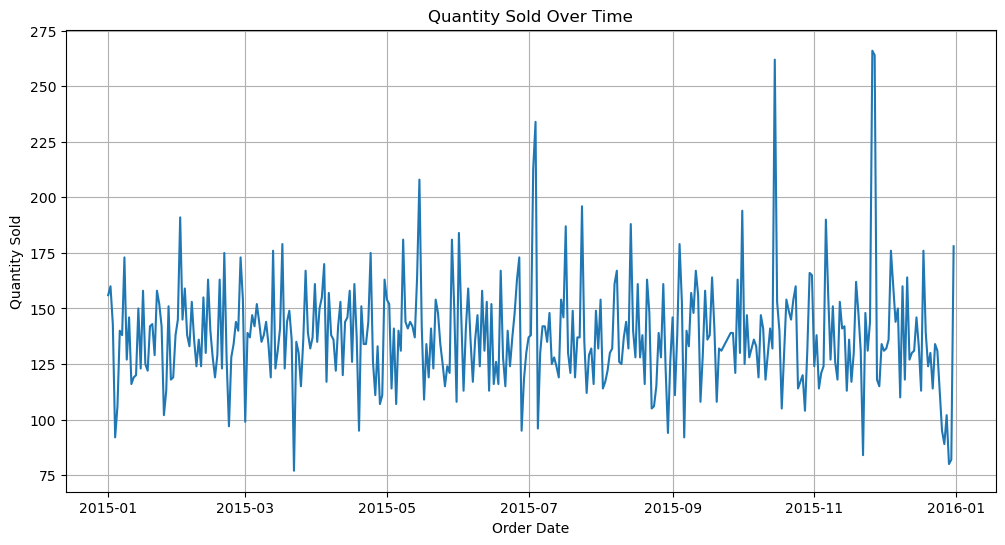

In [31]:
# Group by order date and sum the quantity
import matplotlib.pyplot as plt 

quantity_over_time = pizza_df.groupby('order_date')['quantity'].sum()

# Create the plot
plt.figure(figsize=(12, 6))
plt.plot(quantity_over_time.index, quantity_over_time.values)
plt.xlabel('Order Date')
plt.ylabel('Quantity Sold')
plt.title('Quantity Sold Over Time')
plt.grid(True)
plt.show()


In [35]:
#Testing for Stationary :


from statsmodels.tsa.stattools import adfuller
     

In [37]:
# H0: it is not stationary
# H1: it is stationary

def adf_test(sales):
  result = adfuller(sales)
  print('ADF Statistic: %f' % result[0])
  print('p-value: %f' % result[1])
  print(f'# Lags used: {result[2]}')
  print(f'No of observations used: {result[3]}')
  if result[1] <= 0.05:
    print('we reject the null hypothesis, The series is stationary')
  else:
    print('Not enough statistical evidence to reject null hypothesis, The series is not stationary')
     

In [39]:
adf_test(quantity_over_time)


ADF Statistic: -5.208670
p-value: 0.000008
# Lags used: 15
No of observations used: 342
we reject the null hypothesis, The series is stationary


In [41]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [43]:
eval_data = pizza_df.groupby(['order_date', 'pizza_name'])['quantity'].sum().unstack().fillna(0)


In [45]:
eval_data.head()


pizza_name,The Barbecue Chicken Pizza,The Big Meat Pizza,The Brie Carre Pizza,The Calabrese Pizza,The California Chicken Pizza,The Chicken Alfredo Pizza,The Chicken Pesto Pizza,The Classic Deluxe Pizza,The Five Cheese Pizza,The Four Cheese Pizza,...,The Prosciutto and Arugula Pizza,The Sicilian Pizza,The Soppressata Pizza,The Southwest Chicken Pizza,The Spicy Italian Pizza,The Spinach Pesto Pizza,The Spinach Supreme Pizza,The Spinach and Feta Pizza,The Thai Chicken Pizza,The Vegetables + Vegetables Pizza
order_date,,,,,,,,,,,,,,,,,,,,,
2015-01-01,11.0,5.0,0.0,1.0,4.0,2.0,4.0,10.0,6.0,5.0,...,4.0,4.0,0.0,7.0,5.0,2.0,5.0,2.0,7.0,3.0
2015-01-02,8.0,8.0,0.0,0.0,5.0,1.0,2.0,6.0,6.0,3.0,...,4.0,6.0,4.0,6.0,11.0,2.0,7.0,4.0,9.0,5.0
2015-01-03,7.0,8.0,0.0,1.0,11.0,5.0,3.0,5.0,4.0,7.0,...,7.0,6.0,1.0,5.0,4.0,3.0,2.0,2.0,9.0,7.0
2015-01-04,9.0,0.0,2.0,2.0,5.0,4.0,1.0,4.0,2.0,4.0,...,4.0,3.0,0.0,1.0,4.0,3.0,4.0,3.0,5.0,1.0
2015-01-05,2.0,3.0,2.0,0.0,6.0,8.0,2.0,9.0,5.0,4.0,...,2.0,5.0,2.0,3.0,2.0,4.0,2.0,2.0,6.0,2.0


In [47]:
one_pizza = eval_data['The Barbecue Chicken Pizza']


In [49]:
# split train and test
train = one_pizza[:-7]
test = one_pizza[-7:]

In [ ]:
# Fit Arima model
ari_model = ARIMA(train, order=(1, 1, 0))
ari_result = ari_model.fit()
     

In [ ]:
# forecast
ari_forecast = ari_result.get_forecast(steps=len(test))
ari_fore_values = ari_forecast.predicted_mean

In [ ]:
ari_predict = ari_result.predict(start=len(train), end=len(train)+len(test)-1, dynamic=True)


In [57]:
ari_predict.index = test.index


In [59]:
# concat test and ari_predict without changing the index of test, test is a pandas series

concatenated_series = pd.concat([test, ari_predict], axis=1)
concatenated_series.columns = ['Actual', 'Predicted']
concatenated_series

,Actual,Predicted
order_date,,
2015-12-24,4.0,4.970012
2015-12-26,5.0,5.500450
2015-12-27,4.0,5.227277
2015-12-28,2.0,5.367959
2015-12-29,4.0,5.295509
2015-12-30,6.0,5.332820
2015-12-31,10.0,5.313605


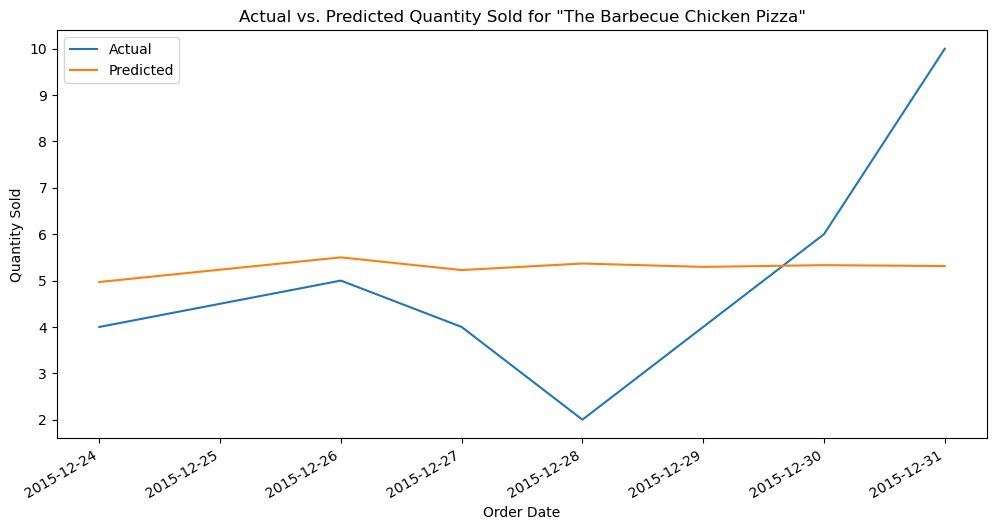

In [61]:
concatenated_series.plot(figsize=(12, 6))
plt.xlabel('Order Date')
plt.ylabel('Quantity Sold')
plt.title('Actual vs. Predicted Quantity Sold for "The Barbecue Chicken Pizza"')
plt.show()

In [63]:
# Evaluate the model
mae = mean_absolute_error(test, ari_fore_values)
mse = mean_squared_error(test, ari_fore_values)
rmse = np.sqrt(mse)

print(f'ARIMA MAE: {mae}')
print(f'ARIMA MSE: {mse}')
print(f'ARIMA RMSE: {rmse}')

ARIMA MAE: 1.8163972887433266
ARIMA MSE: 5.446642862970399
ARIMA RMSE: 2.333804375471603


In [ ]:
# fit SARIMA model
sari_model = SARIMAX(train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 7))
sari_result = sari_model.fit()
     

In [ ]:
# sarima forecast
sari_forecast = sari_result.get_forecast(steps=len(test))
sari_fore_values = sari_forecast.predicted_mean
     

In [69]:
# Evaluate Sarima
mae = mean_absolute_error(test, sari_fore_values)
mse = mean_squared_error(test, sari_fore_values)
rmse = np.sqrt(mse)

print(f'SARIMAX MAE: {mae}')
print(f'SARIMAX MSE: {mse}')
print(f'SARIMAX RMSE: {rmse}')
     

SARIMAX MAE: 2.5756324787208564
SARIMAX MSE: 8.296056595010654
SARIMAX RMSE: 2.8802875889415374


In [71]:
sari_predict = sari_result.predict(start=len(train), end=len(train)+len(test)-1, dynamic=True)


C:\Users\hp\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\hp\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [73]:
sari_predict.index = test.index


In [75]:

sari_predict


order_date
2015-12-24    7.277264
2015-12-26    7.484854
2015-12-27    5.527071
2015-12-28    6.338010
2015-12-29    6.738482
2015-12-30    5.870531
2015-12-31    6.465724
Name: predicted_mean, dtype: float64

In [77]:
concatenated_sarima = pd.concat([test, sari_predict] , axis=1)
concatenated_sarima.columns = ['Actual', 'Predicted']
concatenated_sarima
     

,Actual,Predicted
order_date,,
2015-12-24,4.0,7.277264
2015-12-26,5.0,7.484854
2015-12-27,4.0,5.527071
2015-12-28,2.0,6.338010
2015-12-29,4.0,6.738482
2015-12-30,6.0,5.870531
2015-12-31,10.0,6.465724


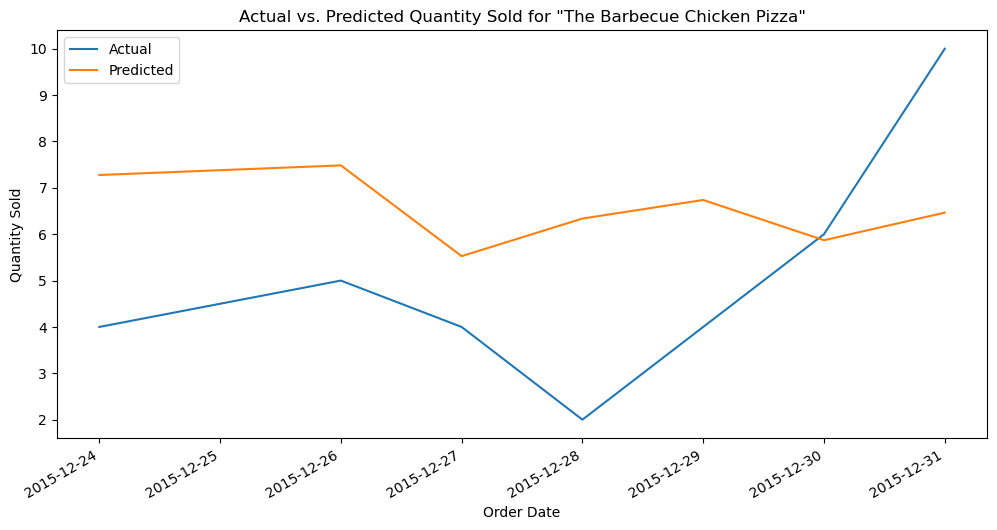

In [79]:
concatenated_sarima.plot(figsize=(12, 6))
plt.xlabel('Order Date')
plt.ylabel('Quantity Sold')
plt.title('Actual vs. Predicted Quantity Sold for "The Barbecue Chicken Pizza"')
plt.show()

In [81]:
from prophet import Prophet


In [83]:
one_pizza_prophet = pd.DataFrame({'ds': one_pizza.index, 'y': one_pizza.values})

one_pizza_prophet.head()

,ds,y
0,2015-01-01,11.0
1,2015-01-02,8.0
2,2015-01-03,7.0
3,2015-01-04,9.0
4,2015-01-05,2.0


In [85]:
# one_pizza_prophet.set_index('ds', inplace=True)

# split train and test
pr_train = one_pizza_prophet[:-7]
pr_test = one_pizza_prophet[-7:]

In [87]:
# fit model prophet
pr_model = Prophet()
pr_model.fit(pr_train)

16:44:07 - cmdstanpy - INFO - Chain [1] start processing
16:44:07 - cmdstanpy - INFO - Chain [1] done processing


In [89]:
# forcast for one week
pr_future = pr_model.make_future_dataframe(periods=7, freq='D')
pr_forecast = pr_model.predict(pr_future)

In [91]:
# extract forecast values
pr_forecast_values = pr_forecast['yhat'][-len(pr_test):].values
     

In [93]:
# Evaluate the model
mae = mean_absolute_error(pr_test['y'], pr_forecast_values)
mse = mean_squared_error(pr_test['y'], pr_forecast_values)
rmse = np.sqrt(mse)

print(f'prophet MAE: {mae}')
print(f'prophet MSE: {mse}')
print(f'prophet RMSE: {rmse}')
     

prophet MAE: 2.7041506900698473
prophet MSE: 8.559382223271792
prophet RMSE: 2.925642189891271


In [95]:
concat_prophet = pd.concat([pr_test, pr_forecast[['yhat']].iloc[-len(pr_test):]], axis=1)
concat_prophet.columns = ['date','Actual', 'Predicted']
concat_prophet.set_index('date', inplace=True)
concat_prophet

,Actual,Predicted
date,,
2015-12-24,4.0,6.713469
2015-12-26,5.0,7.613496
2015-12-27,4.0,6.970675
2015-12-28,2.0,5.363001
2015-12-29,4.0,6.916402
2015-12-30,6.0,5.774931
2015-12-31,10.0,5.873058


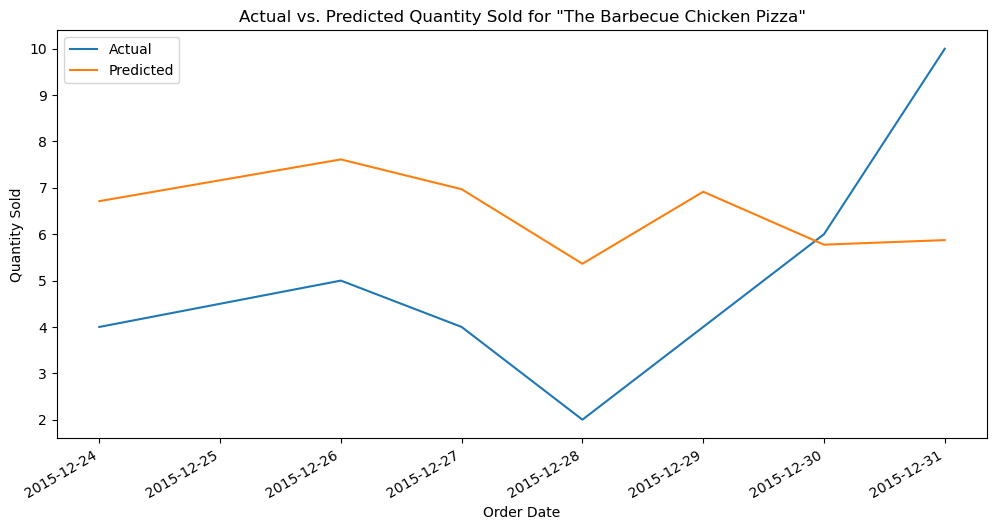

In [97]:
# visualize forecast
concat_prophet.plot(figsize=(12, 6))
plt.xlabel('Order Date')
plt.ylabel('Quantity Sold')
plt.title('Actual vs. Predicted Quantity Sold for "The Barbecue Chicken Pizza"')
plt.show()

In [1]:
#Purchasing
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import LabelEncoder
     

In [3]:
# ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [37]:
pizza_df= pd.read_csv(r"C:\Users\hp\Desktop\Dominos\Pizza_Sale - pizza_sales.csv")
ingred_df= pd.read_csv(r"C:\Users\hp\Desktop\Dominos\Pizza_ingredients - Pizza_ingredients.csv")

In [39]:
pizza_df.dropna(inplace=True)

In [41]:
def parse_dates(date):
  for fmt in ('%d-%m-%Y', '%d/%m/%Y'):
    try:
      return pd.to_datetime(date, format=fmt)
    except ValueError:
      pass
  raise ValueError(f'no valid date format found for {date}')
     

In [43]:
pizza_df['order_date'] = pizza_df['order_date'].apply(parse_dates)


In [44]:
pizza_df = pizza_df[['order_date', 'pizza_name', 'quantity']]


In [45]:
 pizza_df['pizza_name'].unique()


array(['The Hawaiian Pizza', 'The Classic Deluxe Pizza',
       'The Five Cheese Pizza', 'The Italian Supreme Pizza',
       'The Mexicana Pizza', 'The Thai Chicken Pizza',
       'The Prosciutto and Arugula Pizza', 'The Barbecue Chicken Pizza',
       'The Greek Pizza', 'The Spinach Supreme Pizza',
       'The Green Garden Pizza', 'The Italian Capocollo Pizza',
       'The Spicy Italian Pizza', 'The Spinach Pesto Pizza',
       'The Vegetables + Vegetables Pizza', 'The Southwest Chicken Pizza',
       'The California Chicken Pizza', 'The Pepperoni Pizza',
       'The Chicken Pesto Pizza', 'The Big Meat Pizza',
       'The Calabrese Pizza', 'The Four Cheese Pizza',
       'The Italian Vegetables Pizza', 'The Mediterranean Pizza',
       'The Pepper Salami Pizza', 'The Spinach and Feta Pizza',
       'The Napolitana Pizza', 'The Sicilian Pizza',
       'The Chicken Alfredo Pizza',
       'The Pepperoni, Mushroom, and Peppers Pizza',
       'The Soppressata Pizza', 'The Brie Carre Pizza'

In [49]:
sales_summary = pizza_df.groupby(['order_date', 'pizza_name']).sum().reset_index()


In [51]:
sales_summary.head()


,order_date,pizza_name,quantity
0,2015-01-01,The Barbecue Chicken Pizza,11
1,2015-01-01,The Big Meat Pizza,5
2,2015-01-01,The Calabrese Pizza,1
3,2015-01-01,The California Chicken Pizza,4
4,2015-01-01,The Chicken Alfredo Pizza,2


In [53]:
# reshape data for time series modeling
sales_pivot = sales_summary.pivot(index='order_date', columns='pizza_name', values='quantity').fillna(0)
     

In [55]:

arima_models = {}

for pizza_name in sales_pivot.columns:
  try:
    model = ARIMA(sales_pivot[pizza_name], order=(1, 1, 0))
    model_fit = model.fit()
    arima_models[pizza_name] = model_fit
  except:
    print(f'ARIMA model for {pizza_name} failed to fit')

In [57]:
# Generate predictions for one week
prediction_days = 7
predictions_arima = {}

for pizza_name, model in arima_models.items():
  predictions_arima[pizza_name] = model.predict(start=len(sales_pivot), end=len(sales_pivot) + prediction_days - 1)
     

In [59]:
predictions_df = pd.DataFrame(predictions_arima)


In [61]:
predictions_df.index = pd.date_range(start=sales_pivot.index[-1], periods=prediction_days, freq='D')


In [63]:
ingredients_df = ingred_df[['pizza_name', 'pizza_ingredients', 'Items_Qty_In_Grams']]


In [65]:
# change column name to items_qty
ingredients_df.rename(columns={'Items_Qty_In_Grams': 'items_qty'}, inplace=True)
     

In [67]:
predictions_df


,The Barbecue Chicken Pizza,The Big Meat Pizza,The Brie Carre Pizza,The Calabrese Pizza,The California Chicken Pizza,The Chicken Alfredo Pizza,The Chicken Pesto Pizza,The Classic Deluxe Pizza,The Five Cheese Pizza,The Four Cheese Pizza,...,The Prosciutto and Arugula Pizza,The Sicilian Pizza,The Soppressata Pizza,The Southwest Chicken Pizza,The Spicy Italian Pizza,The Spinach Pesto Pizza,The Spinach Supreme Pizza,The Spinach and Feta Pizza,The Thai Chicken Pizza,The Vegetables + Vegetables Pizza
2015-12-31,7.949231,4.420315,0.868806,1.368239,7.0,2.515974,2.139860,6.884102,3.032327,6.974960,...,3.594000,2.583928,2.060907,5.917019,5.844288,3.542421,2.0,3.173030,3.0,7.773728
2016-01-01,9.000644,5.252117,1.508606,2.255787,7.0,3.250085,3.004890,8.502239,4.000261,8.000157,...,4.252945,3.751409,2.501855,5.496557,7.266934,4.250600,2.0,4.007485,3.0,8.764985
2016-01-02,8.461593,4.814122,1.146737,1.773032,7.0,2.886938,2.602621,7.661914,3.524117,7.481141,...,3.944120,3.187265,2.294809,5.689343,6.625582,3.906524,2.0,3.626354,3.0,8.323624
2016-01-03,8.737960,5.044753,1.351409,2.035612,7.0,3.066578,2.789690,8.098308,3.758341,7.743898,...,4.088856,3.459867,2.392027,5.600949,6.914714,4.073697,2.0,3.800433,3.0,8.520142
2016-01-04,8.596269,4.923311,1.235647,1.892789,7.0,2.977715,2.702696,7.871682,3.643122,7.610875,...,4.021023,3.328142,2.346379,5.641478,6.784369,3.992474,2.0,3.720923,3.0,8.432641
2016-01-05,8.668913,4.987258,1.301122,1.970474,7.0,3.021673,2.743152,7.989373,3.699800,7.678219,...,4.052814,3.391794,2.367813,5.622895,6.843130,4.031937,2.0,3.757239,3.0,8.471601
2016-01-06,8.631669,4.953586,1.264089,1.928219,7.0,2.999928,2.724338,7.928254,3.671919,7.644125,...,4.037915,3.361036,2.357748,5.631416,6.816640,4.012764,2.0,3.740652,3.0,8.454254


In [69]:
ingredients_df.head()


,pizza_name,pizza_ingredients,items_qty
0,The Barbecue Chicken Pizza,Barbecued Chicken,40.0
1,The Barbecue Chicken Pizza,Red Peppers,15.0
2,The Barbecue Chicken Pizza,Green Peppers,20.0
3,The Barbecue Chicken Pizza,Tomatoes,30.0
4,The Barbecue Chicken Pizza,Red Onions,60.0


In [81]:
# Create a dictionary to store the ingredient quantities
ingredient_quantities = {}

# Iterate through each pizza in the predictions
for pizza_name in predictions_df.columns:
  # Get the predicted quantity for the pizza
  predicted_quantity = predictions_df[pizza_name].sum()

  # Get the ingredients for the pizza
  pizza_ingredients = ingredients_df[ingredients_df['pizza_name'] == pizza_name]

  # Iterate through each ingredient for the pizza
  for index, row in pizza_ingredients.iterrows():
    ingredient = row['pizza_ingredients']
    ingredient_qty = row['items_qty']

    # Calculate the required quantity of the ingredient
    required_quantity = predicted_quantity * ingredient_qty

    # Add the required quantity to the dictionary
    if ingredient not in ingredient_quantities:
      ingredient_quantities[ingredient] = 0
    ingredient_quantities[ingredient] += required_quantity



In [83]:
# Create a DataFrame from the ingredient quantities
ingredient_requirements_df = pd.DataFrame.from_dict(ingredient_quantities, orient='index', columns=['required_quantity'])    

In [77]:
# Print the ingredient requirements
ingredient_requirements_df

,required_quantity
Barbecued Chicken,5404.165210
Red Peppers,11341.552000
Green Peppers,8030.393870
Tomatoes,34984.718345
Red Onions,54797.556520
...,...
Luganega Sausage,2767.612913
Onions,1383.806456
Soppressata Salami,4896.461505
Peperoncini verdi,1412.869705


In [79]:
# Create a purchase order DataFrame
purchase_order_df = ingredient_requirements_df.copy()

# Add a column for the unit of measure (assuming all ingredients are in grams)
purchase_order_df['unit'] = 'grams'

# Rename the columns for better readability
purchase_order_df = purchase_order_df.rename(columns={'required_quantity': 'quantity'})

# Add a header to the purchase order
print('Purchase Order:')
print('----------------')

# Print the purchase order table
print(purchase_order_df.to_string())

Purchase Order:
----------------
                                quantity   unit
Barbecued Chicken            5404.165210  grams
Red Peppers                 11341.552000  grams
Green Peppers                8030.393870  grams
Tomatoes                    34984.718345  grams
Red Onions                  54797.556520  grams
Barbecue Sauce               1801.388403  grams
Bacon                       19992.004778  grams
Pepperoni                   24192.916443  grams
Italian Sausage               343.954622  grams
Chorizo Sausage              1719.773109  grams
Brie Carre Cheese             260.292443  grams
Prosciutto                    260.292443  grams
Caramelized Onions                   NaN  grams
Pears                          86.764148  grams
Thyme                          43.382074  grams
Garlic                      17939.075394  grams
?duja Salami                 1586.898271  grams
Pancetta                     2380.347406  grams
Friggitello Peppers           396.724568  grams
Chicken